In [1]:
import pandas as pd
import numpy as np
from openclean.data.load import dataset
from openclean.pipeline import stream
from openclean.cluster.knn import knn_clusters, knn_collision_clusters
from openclean.function.similarity.base import SimilarityConstraint
from openclean.function.similarity.text import LevenshteinDistance
from openclean.function.value.threshold import GreaterThan
from openclean.function.value.null import is_empty
from openclean.operator.transform.update import update

In [2]:
pd.set_option('display.max_rows', None)

root = '../Dataset/'

files = [
    'DOB_Certificate_Of_Occupancy.csv', 
    'DOB_NOW__Build___Approved_Permits.csv', 
    'DOB_Stalled_Construction_Sites.csv', 
    'Interagency_Coordination_and_Construction_Permits_Data__MOSYS_.csv',
    'Active_Projects_Under_Construction.csv',
    'FY19_BID_Trends_Report_Data.csv',
    'DOB_NOW__Electrical_Permit_Applications.csv', 
    'DOB_NOW__Safety___Facades_Compliance_Filings.csv', 
    'DOB_Sign_Application_Filings.csv', 
]


#Data column of Borough in different files
columns = [
    'BOROUGH', 
    'Borough', 
    'Borough Name', 
    'Borough',
    'Borough',
    'Borough',
    'BOROUGH',
    'BOROUGH',
    'Borough'
]

# Current Profile


In [3]:
# add all borough columns to one dataframe, then generate the data profile
df = pd.DataFrame(columns=['BOROUGH'])
for file in files:
    path = root + file
    ds = dataset(path, encoding='utf-8')
    print("Loading... ", file)
    # rename all borough col to BOROUGH
    ds.rename(columns={'Borough': 'BOROUGH', 'Borough Name': 'BOROUGH'}, inplace=True)
    borough = ds[['BOROUGH']]
    df = df.append(borough)
print(df.value_counts())

Loading...  DOB_Certificate_Of_Occupancy.csv
Loading...  DOB_NOW__Build___Approved_Permits.csv
Loading...  DOB_Stalled_Construction_Sites.csv
Loading...  Interagency_Coordination_and_Construction_Permits_Data__MOSYS_.csv
Loading...  Active_Projects_Under_Construction.csv
Loading...  FY19_BID_Trends_Report_Data.csv
Loading...  DOB_NOW__Electrical_Permit_Applications.csv
Loading...  DOB_NOW__Safety___Facades_Compliance_Filings.csv
Loading...  DOB_Sign_Application_Filings.csv
BOROUGH                                          
Brooklyn                                             436310
Queens                                               367774
MANHATTAN                                            230619
Manhattan                                            213316
BROOKLYN                                             144814
Bronx                                                119777
QUEENS                                               111171
Staten Island                                       

# Apply Original Method

In [4]:
# For our original method, we firstly use value_counts method to check if there is any empty value, then we repleace them with 'UNKNOWN'. 
# Then we make all the values in this column uppercase
def getNoneIdx(df, column):
    res = set()
    idx = 0
    for name in df[column]:
        if name is None or (len(name) == 0):
            res.add(idx)
        idx += 1
    return res


def original_cleaning_method(df, column):
    mask = df[column] != df[column].str.upper()
    upper_rows_index = set(df.loc[mask].index.to_list())
    df = update(df, columns=column, func=str.upper)
    empty_rows_index = getNoneIdx(df, column)
    df = update(df, columns=column, func=lambda x: 'UNKNOWN' if is_empty(x) else x)
    affected_count = len(upper_rows_index.union(empty_rows_index))
    return df, affected_count

def calc_precision_recall(remain_problems_rows_count, cleaned_rows_count):
    total = remain_problems_rows_count + cleaned_rows_count
    precision = (cleaned_rows_count - remain_problems_rows_count) / cleaned_rows_count if cleaned_rows_count != 0 else 0.0
    recall = (cleaned_rows_count - remain_problems_rows_count) / total if total != 0 else 0.0
    print(f'The precision value should be {precision} and the recall value should be {recall}')

(df_original_clean, count) = original_cleaning_method(df, 'BOROUGH')

In [5]:
df_original_clean['BOROUGH'].value_counts()

BROOKLYN                                             581124
QUEENS                                               478945
MANHATTAN                                            443935
BRONX                                                177071
STATEN ISLAND                                        133217
STATEN IS                                               393
BROOKLYN                                                355
QUEENS                                                  335
BRONX                                                   206
K                                                       183
Q                                                       182
X                                                        98
M                                                        93
R                                                        51
MN                                                       25
BK                                                       23
BRONX;#BROOKLYN;#MANHATTAN;#QUEENS;#STAT

In [6]:
# Calculate the precision and call of the original method
# Based on the result of value_counts, we found that the total number of question rows should be 110797
# the number of question rows that have been modified is 1108732, and the number of rows which still contain problems is 2065

calc_precision_recall(2065, count)

The precision value should be 0.9981375120407817 and the recall value should be 0.996281948906956


In [7]:
# Save the reference data
df.to_csv('../Reference Data/original_version_borough.csv', index=None)
df_original_clean.to_csv('../Reference Data/original_method_borough.csv', index=None)

# Apply Refined Method

In [8]:
# Perform KNN to detect spelling errors
df = stream('../Reference Data/original_version_borough.csv')

In [9]:
def print_cluster(cnumber, cluster):
    print('Cluster {} (of size {})\n'.format(cnumber, len(cluster)))
    for val, count in cluster.items():
        print('{} ({})'.format(val, count))
    print('\nSuggested value: {}\n\n'.format(cluster.suggestion()))
    
# Minimum cluster size. Use ten as default (to limit
# the number of clusters that are printed in the next cell).
def run_knn(df, column, t=0.5, minsize = 2):
    dba = df.select(column).distinct()
    clusters = knn_clusters(
        values=dba,
        sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)),
        minsize=minsize
    )
    print('{} clusters of size {} or greater'.format(len(clusters), minsize))
    # Sort clusters by decreasing number of distinct values.
    clusters.sort(key=lambda c: len(c), reverse=True)
    for i, cluster in enumerate(clusters):
        print_cluster(i + 1, cluster)
        
run_knn(df, 'BOROUGH')


39 clusters of size 2 or greater
Cluster 1 (of size 11)

Queens;#Brooklyn (3)
Bronx;#Brooklyn;#Manhattan;#Queens;#Staten Island (14)
Bronx;#Brooklyn;#Queens;#Staten Island;#Manhattan (1)
Queens;#Manhattan;#Brooklyn;#Staten Island (1)
Bronx;#Queens;#Staten Island (1)
Manhattan;#Brooklyn;#Bronx;#Queens;#Staten Island (1)
Bronx;#Brooklyn;#Queens;#Staten Island (1)
Brooklyn;#Staten Island (3)
Bronx;#Brooklyn;#Manhattan (2)
Brooklyn;#Manhattan;#Staten Island (1)
Queens;#Brooklyn;#Staten Island (1)

Suggested value: Bronx;#Brooklyn;#Manhattan;#Queens;#Staten Island


Cluster 2 (of size 10)

Bronx;#Brooklyn;#Queens;#Staten Island;#Manhattan (1)
Bronx;#Brooklyn;#Manhattan;#Queens (3)
Queens;#Manhattan;#Brooklyn;#Staten Island (1)
Bronx;#Queens;#Staten Island (1)
Manhattan;#Brooklyn;#Bronx;#Queens;#Staten Island (1)
Queens;#Brooklyn;#Staten Island (1)
Bronx;#Brooklyn;#Queens;#Staten Island (1)
Bronx;#Brooklyn;#Manhattan (2)
Brooklyn;#Manhattan;#Staten Island (1)
Bronx;#Brooklyn;#Manhattan;#Quee

In [10]:
# First apply the original method again
df = df.to_df()
(df_clean, count) = original_cleaning_method(df, 'BOROUGH')

In [11]:
df_clean.BOROUGH.value_counts()

BROOKLYN                                             581124
QUEENS                                               478945
MANHATTAN                                            443935
BRONX                                                177071
STATEN ISLAND                                        133217
STATEN IS                                               393
BROOKLYN                                                355
QUEENS                                                  335
BRONX                                                   206
K                                                       183
Q                                                       182
X                                                        98
M                                                        93
R                                                        51
MN                                                       25
BK                                                       23
BRONX;#BROOKLYN;#MANHATTAN;#QUEENS;#STAT

In [12]:
# We firstly convert all words containing # to unknown
df_clean = update(df_clean, columns='BOROUGH', func=lambda x : 'UNKNOWN' if '#' in x else x)

In [13]:
df_clean['BOROUGH'].unique()

array(['QUEENS', 'BROOKLYN', 'STATEN ISLAND', 'MANHATTAN', 'BRONX',
       'UNKNOWN', 'BROOKLYN ', 'QUEENS   ', 'BRONX    ', 'STATEN IS', 'Q',
       'K', 'R', 'X', 'M', 'MN', 'BX', 'QN', 'BK', 'SI'], dtype=object)

In [14]:
# Then we noticed that there are some blanks after BROOKLYN and QUEENS, thus we decided to remove those blanks
df_clean = update(df_clean, columns='BOROUGH', func=lambda x : str(x).strip())

In [15]:
df_clean.value_counts()

BOROUGH      
BROOKLYN         581479
QUEENS           479280
MANHATTAN        443935
BRONX            177277
STATEN ISLAND    133217
STATEN IS           393
K                   183
Q                   182
X                    98
UNKNOWN              94
M                    93
R                    51
MN                   25
BK                   23
QN                   13
BX                   10
SI                    4
dtype: int64

In [16]:
# We noticted that abbreviations for the borough, such as "Q" (for "QUEENS"), "M" (for "MANHATTAN") and "BK" (for "BROOKLYN") were also included on the map.
# Our new strategy was to map the unformatted value obtained from the initial dataset to the formatted reference data.
mapper = {'K': 'BROOKLYN', 'Q': 'QUEENS', 'X': 'BRONX', 'M': 'MANHATTAN', 'R': 'STATEN ISLAND', 'MN': 'MANHATTAN', 'BK': 'BROOKLYN', 'STATEN IS': 'STATEN ISLAND', 'QN': 'QUEENS', 'BX': 'BRONX', 'SI': 'STATEN ISLAND'}
df_clean = update(df_clean, columns='BOROUGH', func=lambda x : mapper.get(str(x)) if x in mapper else x)

In [17]:
df_clean.value_counts()

BOROUGH      
BROOKLYN         581685
QUEENS           479475
MANHATTAN        444053
BRONX            177385
STATEN ISLAND    133665
UNKNOWN              94
dtype: int64

In [18]:
# Now we encapsulate our refined method in a function
def refined_method(df, column):
    mapper = {'K': 'BROOKLYN', 'Q': 'QUEENS', 'X': 'BRONX', 'M': 'MANHATTAN', 'R': 'STATEN ISLAND', 'MN': 'MANHATTAN', 'BK': 'BROOKLYN', 'STATEN IS': 'STATEN ISLAND', 'QN': 'QUEENS', 'BX': 'BRONX', 'SI': 'STATEN ISLAND'}
    df = update(df, columns=column, func=lambda x: 'UNKNOWN' if is_empty(x) else x)
    df = update(df, columns=column, func=lambda x: str(x).strip())
    df = update(df, columns=column, func=str.upper) 
    df = update(df, columns=column, func=lambda x : 'UNKNOWN' if '#' in x else x)
    df = update(df, columns=column, func=lambda x : mapper.get(str(x)) if x in mapper else x)
    df = update(df, columns=column, func=lambda x : 'UNKNOWN' if x == 'NAN' else x)
    return df

# Apply new method to all datasets

## For dataset DOB_Certificate_Of_Occupancy.csv

In [19]:
df = pd.read_csv(root + files[0], low_memory=False)
df[columns[0]].value_counts()

Manhattan        61254
Brooklyn         27484
Queens           24768
Bronx            11297
Staten Island     8154
Name: BOROUGH, dtype: int64

In [20]:
df = refined_method(df, columns[0])
df.to_csv('../Resultset/Borough_res_1.csv')

In [21]:
# After cleaning the data, show the visualization.
import matplotlib.pyplot as plt
plt.style.use('seaborn')

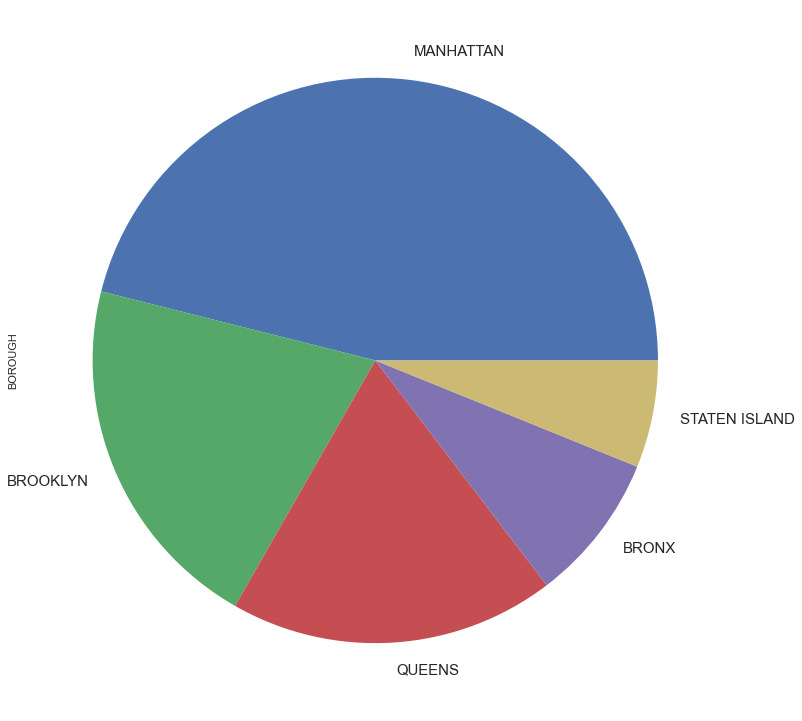

In [22]:
df[columns[0]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()

## For dataset DOB_NOW__Build___Approved_Permits.csv

In [23]:
df = pd.read_csv(root + files[1], low_memory=False)
df[columns[1]].value_counts()

MANHATTAN        104181
BROOKLYN          62626
QUEENS            41561
BRONX             22068
STATEN ISLAND     11009
Name: Borough, dtype: int64

In [24]:
df = refined_method(df, columns[1])
df.to_csv('../Resultset/Borough_res_2.csv')

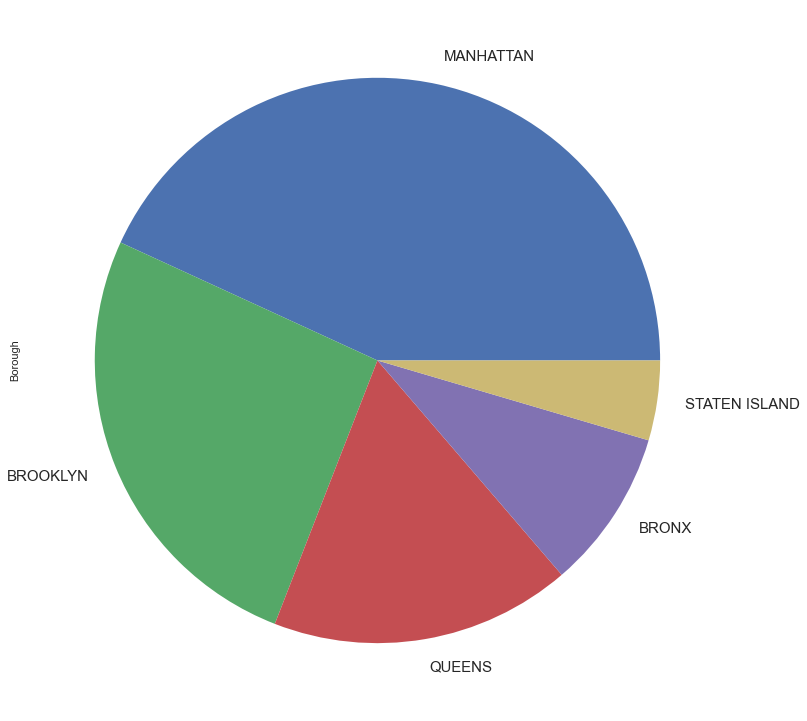

In [25]:
# After cleaning the data, show the visualization.
df[columns[1]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()

## For dataset DOB_Stalled_Construction_Sites.csv

In [26]:
df = pd.read_csv(root + files[2])
df[columns[2]].value_counts()

Brooklyn         408626
Queens           342790
Manhattan        151810
Bronx            108352
Staten Island     97141
Name: Borough Name, dtype: int64

In [27]:
df = refined_method(df, columns[2])
df.to_csv('../Resultset/Borough_res_3.csv')

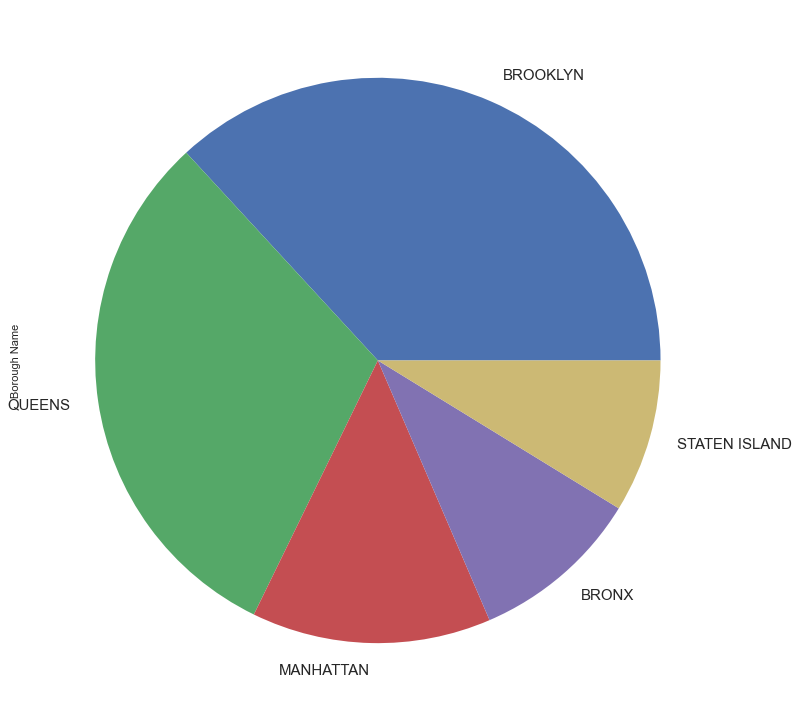

In [28]:
# After cleaning the data, show the visualization.
df[columns[2]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()

## For dataset Interagency_Coordination_and_Construction_Permits_Data__MOSYS_.csv

In [29]:
df = pd.read_csv(root + files[3])
df[columns[3]].value_counts()

Manhattan                                            252
Queens                                               216
Brooklyn                                             200
Bronx                                                128
Staten Island                                         75
Bronx;#Brooklyn;#Manhattan;#Queens;#Staten Island     14
Manhattan;#Queens                                      7
Staten Island;#Queens;#Manhattan;#Brooklyn;#Bronx      4
Bronx;#Manhattan                                       4
Brooklyn;#Manhattan                                    3
Brooklyn;#Staten Island                                3
Queens;#Bronx                                          3
Manhattan;#Bronx                                       3
Bronx;#Brooklyn;#Manhattan;#Queens                     3
Manhattan;#Brooklyn                                    3
Bronx;#Queens                                          3
Queens;#Brooklyn                                       3
Brooklyn;#Bronx;#Manhattan;#Que

In [30]:
df = refined_method(df, columns[3])
df.to_csv('../Resultset/Borough_res_4.csv')

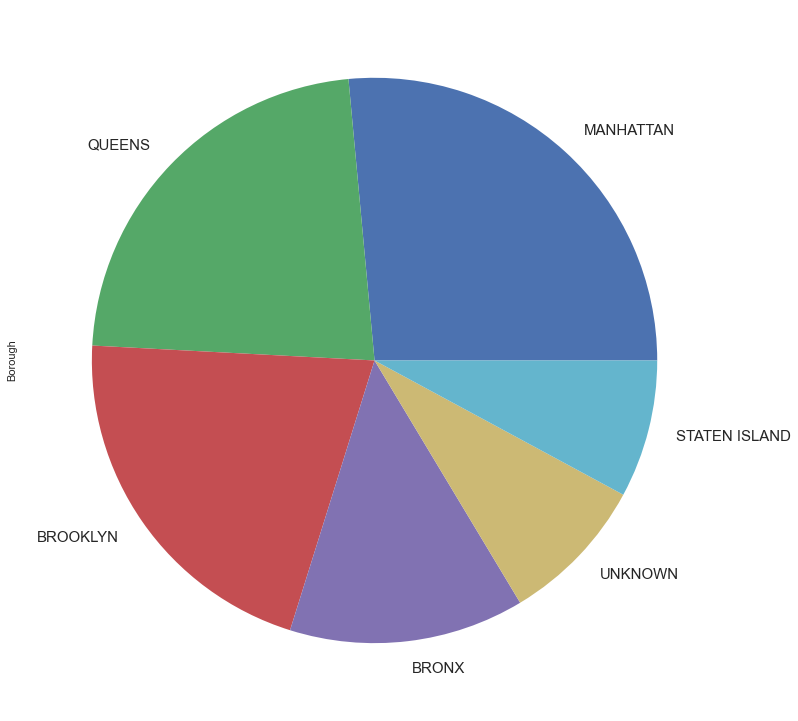

In [31]:
# After cleaning the data, show the visualization.
df[columns[3]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()

## For dataset Active_Projects_Under_Construction.csv

In [32]:
df = pd.read_csv(root + files[4])
df[columns[4]].value_counts()

QUEENS       1323
BROOKLYN     1291
BRONX         846
MANHATTAN     733
STATEN IS     393
BROOKLYN      355
QUEENS        335
BRONX         206
K             183
Q             182
X              98
M              93
R              51
Name: Borough, dtype: int64

In [33]:
df = refined_method(df, columns[4])
df.to_csv('../Resultset/Borough_res_5.csv')

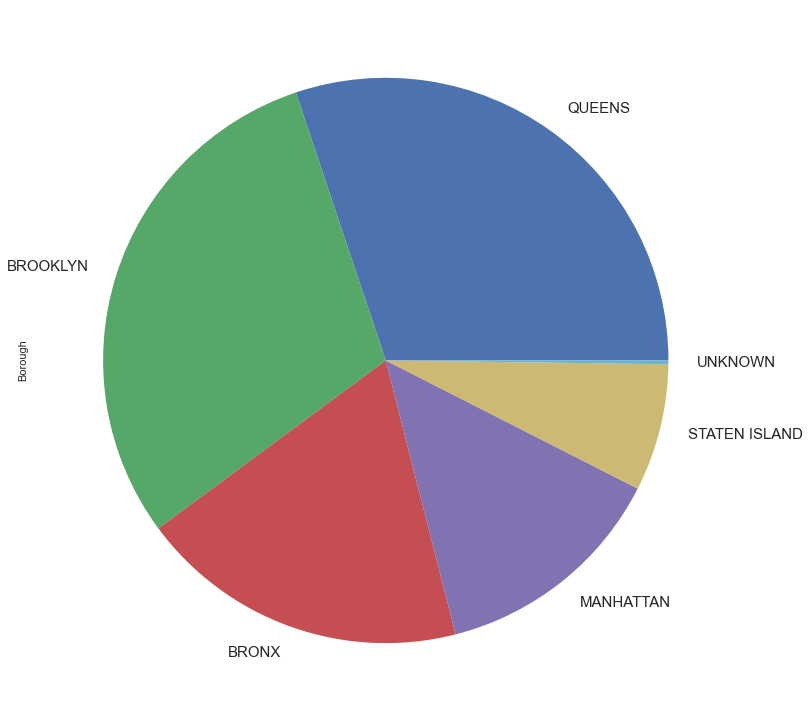

In [34]:
# After cleaning the data, show the visualization.
df[columns[4]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()

## For dataset FY19_BID_Trends_Report_Data.csv

In [35]:
df = pd.read_csv(root + files[5])
df[columns[5]].value_counts()

MN    25
BK    23
QN    13
BX    10
SI     4
Name: Borough, dtype: int64

In [36]:
df = refined_method(df, columns[5])
df.to_csv('../Resultset/Borough_res_6.csv')

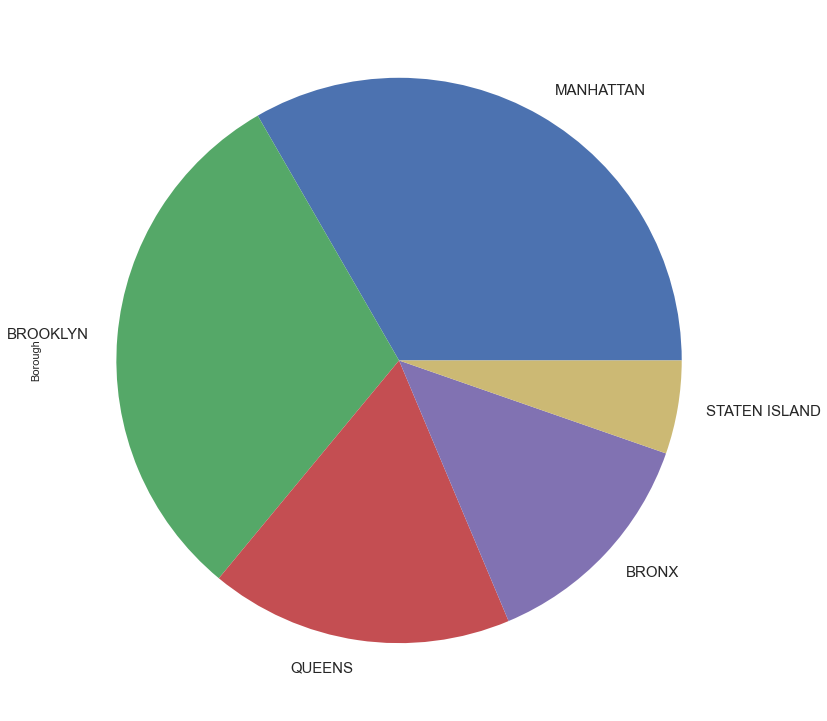

In [37]:
# After cleaning the data, show the visualization.
df[columns[5]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()

## For dataset DOB_NOW__Electrical_Permit_Applications.csv

In [38]:
df = pd.read_csv(root + files[6], low_memory=False)
df[columns[6]].value_counts()

MANHATTAN        87469
BROOKLYN         69383
QUEENS           58340
BRONX            25124
STATEN ISLAND    15222
Name: BOROUGH, dtype: int64

In [39]:
df = refined_method(df, columns[6])
df.to_csv('../Resultset/Borough_res_7.csv')

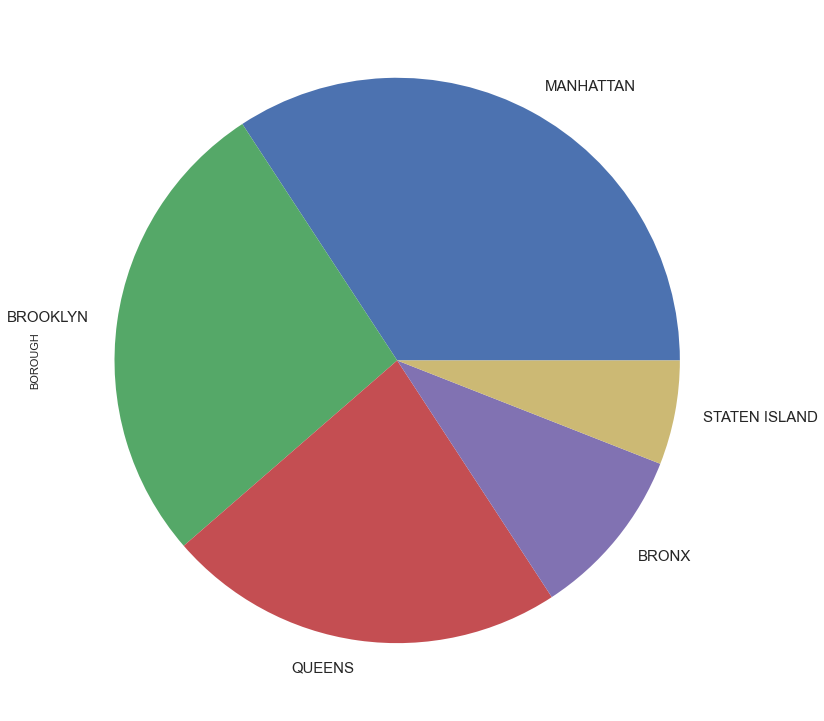

In [40]:
# After cleaning the data, show the visualization.
df[columns[6]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()

## For dataset DOB_NOW__Safety___Facades_Compliance_Filings.csv

In [41]:
df = pd.read_csv(root + files[7], low_memory=False)
df[columns[7]].value_counts()

MANHATTAN        32365
BROOKLYN          8043
BRONX             7555
QUEENS            6739
STATEN ISLAND      579
Name: BOROUGH, dtype: int64

In [42]:
df = refined_method(df, columns[7])
df.to_csv('../Resultset/Borough_res_8.csv')

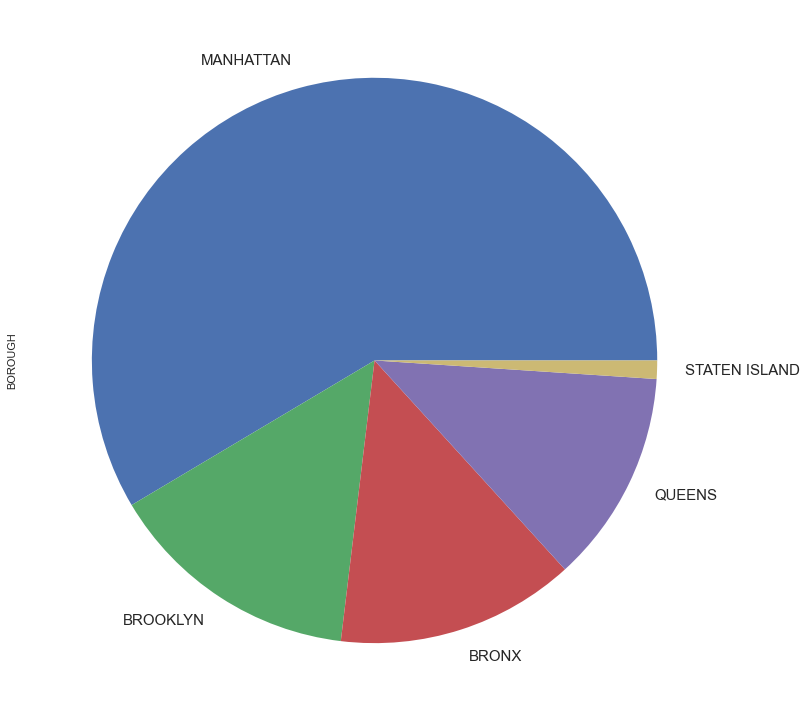

In [43]:
# After cleaning the data, show the visualization.
df[columns[7]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()

## For dataset DOB_Sign_Application_Filings.csv

In [44]:
df = pd.read_csv(root + files[8])
df[columns[8]].value_counts()

MANHATTAN        5871
BROOKLYN         3471
QUEENS           3208
BRONX            1701
STATEN ISLAND    1037
Name: Borough, dtype: int64

In [45]:
df = refined_method(df, columns[8])
df.to_csv('../Resultset/Borough_res_9.csv')

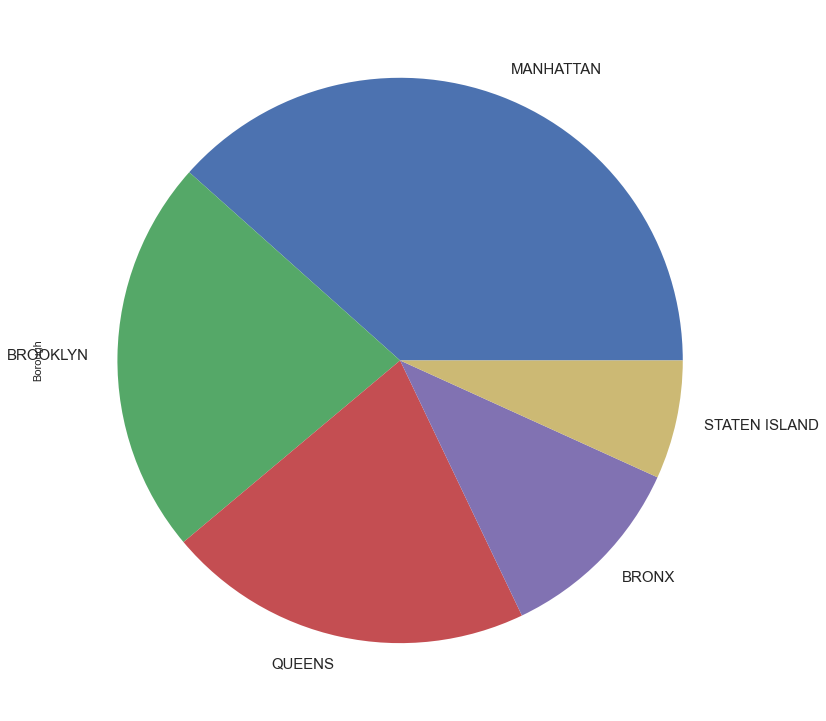

In [46]:
# After cleaning the data, show the visualization.
df[columns[8]].value_counts().plot(kind='pie', figsize=(15, 13), fontsize=15)
plt.show()